In [ ]:
# install the required packages
!pip install bioread
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tk


In [1]:
# import the necessary libraries
try:
    import bioread
    import matplotlib.pyplot as plt
    import os
    import pandas as pd
    import numpy as np
    import tkinter as tk
    from tkinter import filedialog
    current_path = os.getcwd()
    print("All necessary libraries are installed successfully")
    print("Current working directory is: ", current_path)
except ImportError:
    print("Please install the necessary libraries using 'pip install -r requirements.txt' before running the script")
    exit(1)
    

All necessary libraries are installed successfully
Current working directory is:  c:\Git\msk_modelling_python\src\neuro


C:\Users\Bas\ucloud\BSc_thesis_S2024\Lukas_Weilharter\data\session9\RC.acq


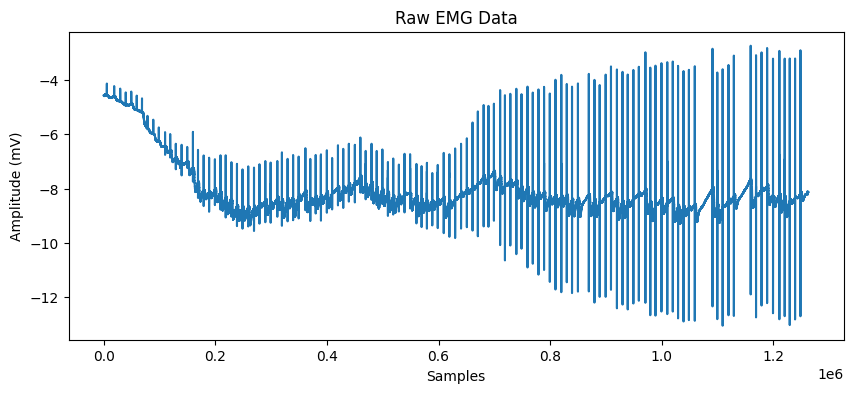

EMG data: [-4.56848145 -4.57000732 -4.5715332  ... -8.13140869 -8.13293457
 -8.13598633]
EMG data type: <class 'numpy.ndarray'>
sampling rate: 1000.0


In [6]:
# Load data and print some information
file_path = r"C:\Users\Bas\ucloud\BSc_thesis_S2024\Lukas_Weilharter\data\session9\RC.acq"
print(file_path)

if not os.path.exists(file_path):
    print('File not found')
    exit(1)

try:
    data = bioread.read_file(file_path)
    emg_data = data.channels[0].data
    fs = data.samples_per_second
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(emg_data)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (mV)')
    plt.title('Raw EMG Data')
    plt.show()

    print('EMG data:', emg_data)
    print('EMG data type:', type(emg_data))
    print('sampling rate:', fs) 
except Exception as e:
    print('Error reading file:', e)
    exit(1)




In [4]:
data = bioread.read_file(file_path)

IndexError: list index out of range

In [32]:
def split_and_save_to_csv(data, sample_rate, filename_base, chunk_size_seconds=10):
  """
  Splits a NumPy ndarray (data) into sections of specified size (chunk_size_seconds)
  based on the sample rate and saves them as separate CSV files with an incremental base filename.
  For each chunk, it finds the first peak above a threshold and all peak frames, storing them in a list.

  Args:
      data: The NumPy ndarray to be split.
      sample_rate: The sampling rate of the data in Hz.
      filename_base: The base filename for the output CSV files (e.g., "my_data_").
      chunk_size_seconds: The size of each chunk in seconds (default: 10).

  Returns:
      A list of lists, where each inner list contains peak frames for a corresponding chunk.
  """
  # Calculate chunk size in samples
  chunk_size_samples = int(chunk_size_seconds * sample_rate)

  # Split the data into chunks
  chunks = np.array_split(data, len(data) // chunk_size_samples)

  # List to store peak frames for each chunk
  peak_frames_list = []
  count = 0
  # Save each chunk and find peaks
  for i, chunk in enumerate(chunks):

    # Find peaks
    peaks = []
    # Calculate threshold based on first 0.5 seconds (assuming integer sample rate)
    half_second_samples = int(sample_rate * 0.5)
    average_first_half = np.mean(chunk[:half_second_samples])
    threshold = average_first_half + 0.05 * np.abs(average_first_half)  # Adjust factor as needed

    for j in range(1, len(chunk) - 1):  # Avoid first and last element for peak detection
      if chunk[j] > threshold and chunk[j] > chunk[j - 1] and chunk[j] > chunk[j + 1]:
        peaks.append(j)  # Store frame index of the peak
        if len(peaks) == 1:  # Only store the first peak if desired (modify condition)
          count += 1
          filename = f"{filename_base}{count}.csv"
          ms_to_add = 50
          add_frames = int(ms_to_add/1000*fs)+2
          chunk_cropped = chunk[peaks[0]-2:peaks[0]+add_frames]
          np.savetxt(filename, chunk_cropped, delimiter=",")  # Use "," as delimiter by default

          # M-wave calculate peak to peak amplitude after 12 miliseconds
          try:
            m_time_frame = int(0.012*fs)
            peak_to_peak_m = np.max(chunk_cropped[5:m_time_frame]) - np.min(chunk_cropped[3:m_time_frame])
          except:
            peak_to_peak_m = np.nan

          # H-reflex calculate peak to peak amplitude after between 15 and 35 miliseconds
          try:
            h_time_frame = int(0.030*fs)
            h_time_frame_end = int(0.045*fs)
            peak_to_peak_h = np.max(chunk_cropped[h_time_frame:h_time_frame_end]) - np.min(chunk_cropped[h_time_frame:h_time_frame_end])
          except:
            peak_to_peak_h = np.nan

          peak_frames_list.append({"filename": os.path.basename(filename), "peak_frame": peaks,
                                   "peak_to_peak_m": peak_to_peak_m, "peak_to_peak_h": peak_to_peak_h})
                                  
          break

  peak_frames_df = pd.DataFrame(peak_frames_list)
  return peak_frames_df


save_path = os.path.join(os.path.dirname(file_path), 'splits',"data_segments_")
peak_frames_per_chunk = split_and_save_to_csv(emg_data, fs, save_path, chunk_size_seconds=2)
peak_frames_per_chunk.to_csv(os.path.join(os.path.dirname(save_path),"peak_frames_per_chunk.csv"), index=False)
print('save data in:' , os.path.dirname(file_path))

save data in: C:\Users\Bas\ucloud\BSc_thesis_S2024\Lukas_Weilharter\data\session9


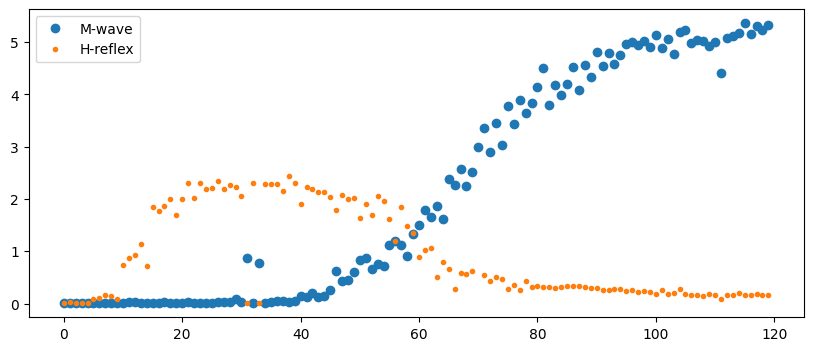

In [37]:
# average every 5 frames
m = peak_frames_per_chunk["peak_to_peak_m"].rolling(1).mean()
h = peak_frames_per_chunk["peak_to_peak_h"].rolling(1).mean()
x = np.arange(len(m))

# plotting peak frames
plt.figure(figsize=(10, 4))
plt.plot(x,m,marker='o', linestyle='None')
plt.plot(x,h,marker='.', linestyle='None')
plt.legend(["M-wave", "H-reflex"])

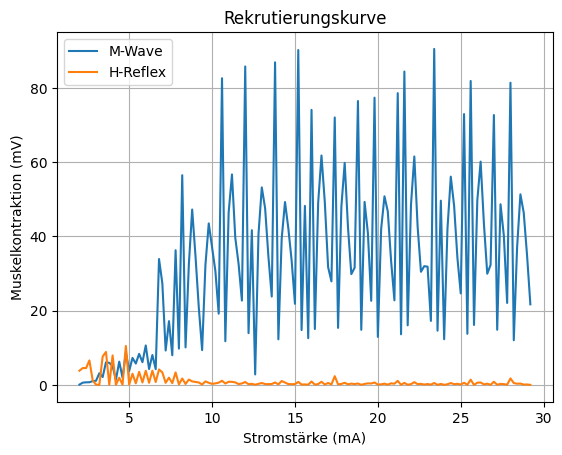

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bioread

# Funktion zum Laden der .acq-Datei
def load_acq_file(file_path):
    data = bioread.read_file(file_path)
    return data

# Funktion zur Erkennung der Stimuli-Spikes
def detect_stimuli_spikes(emg_data, threshold):
    spikes = np.where(emg_data > threshold)[0]
    return spikes

# Funktion zur Verarbeitung der Daten
def process_data(data, threshold):
    emg_data = data.channels[0].data
    time_index = data.channels[0].time_index
    stimulus_spikes = detect_stimuli_spikes(emg_data, threshold)
    stimulus_intervals = []
    m_wave_amplitudes = []
    h_reflex_amplitudes = []

    for i in range(0, len(stimulus_spikes) - 1, 2):
        stimulus_time = time_index[stimulus_spikes[i]]
        stimulus_intervals.append(stimulus_time)

        m_wave_window = emg_data[(time_index >= stimulus_time + 0.005) & (time_index < stimulus_time + 0.025)]
        h_reflex_window = emg_data[(time_index >= stimulus_time + 0.030) & (time_index < stimulus_time + 0.045)]

        if m_wave_window.size > 0:
            m_wave_amplitude = np.ptp(m_wave_window)
        else:
            m_wave_amplitude = 0

        if h_reflex_window.size > 0:
            h_reflex_amplitude = np.ptp(h_reflex_window)
        else:
            h_reflex_amplitude = 0

        m_wave_amplitudes.append(m_wave_amplitude)
        h_reflex_amplitudes.append(h_reflex_amplitude)

    return stimulus_intervals, m_wave_amplitudes, h_reflex_amplitudes

# Funktion zum Plotten der Rekrutierungskurve
def plot_recruitment_curve(stimulus_intervals, m_wave_amplitudes, h_reflex_amplitudes):
    current_steps = np.arange(2, 2 + 0.2 * (len(stimulus_intervals) // 2), 0.2)
    m_wave_avg = np.mean(np.reshape(m_wave_amplitudes[:len(current_steps)*2], (-1, 2)), axis=1)
    h_reflex_avg = np.mean(np.reshape(h_reflex_amplitudes[:len(current_steps)*2], (-1, 2)), axis=1)

    plt.figure()
    plt.plot(current_steps, m_wave_avg, label='M-Wave')
    plt.plot(current_steps, h_reflex_avg, label='H-Reflex')
    plt.xlabel('Stromstärke (mA)')
    plt.ylabel('Muskelkontraktion (mV)')
    plt.title('Rekrutierungskurve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hauptfunktion
def main(file_path, threshold):
    data = load_acq_file(file_path)
    stimulus_intervals, m_wave_amplitudes, h_reflex_amplitudes = process_data(data, threshold)
    plot_recruitment_curve(stimulus_intervals, m_wave_amplitudes, h_reflex_amplitudes)

# Beispielaufruf: Ersetzen Sie 'your_file_path.acq' durch den Pfad zu Ihrer .acq-Datei und passen Sie den Schwellenwert an
if __name__ == '__main__':
    main('/rc_good_lateral_part_LG.acq', threshold=2)  # Threshold in mV

